# What's in our codebase?

Robojackets is an organization that has been around more than 20 years, and Robocup has been one of the teams in Robojackets for almost 15 of those. In addition, members of the team are rarely able to stay in the organization for more than a couple of years because they graduate from the university. While leadership is generally passed down effectively, it rarely stays in the hands of the same members for an extended period of time. This can make it difficult to stay organized and keep consistent goals. With these facts in mind, I wanted to explore the main contribution of my subteam (software) and whether our progress as shown in the codebase's data actually aligns with our current goals.

In [1]:
import json
import pandas as pd
from collections import defaultdict
import re
import wordcloud
import matplotlib.pyplot as plt

## Examining the issues

Goals and progress for a team working on the same project can be communicated in many ways. In programming, engineers who work on the same codebase often signal each other about what they are working on through creating issues and pull requests (a request to update the code base). Here we'll examine the most recent open issues in the codebase obtained through GitHub's API and saved as JSON data.

In [2]:
file_path = "robocup-issues1.json"
issues_df = pd.read_json(file_path)

We are examining the most recent 60 issues in this dataset. Some of these are also pull requests (but not all of them).

In [3]:
issues_df.shape

(60, 28)

Here's some of the data contained in the JSON file. Some of this information, like the API url's, is not particular useful for our purposes.

In [4]:
issues_df.head()

url  \
0  https://api.github.com/repos/RoboJackets/roboc...   
1  https://api.github.com/repos/RoboJackets/roboc...   
2  https://api.github.com/repos/RoboJackets/roboc...   
3  https://api.github.com/repos/RoboJackets/roboc...   
4  https://api.github.com/repos/RoboJackets/roboc...   

                                      repository_url  \
0  https://api.github.com/repos/RoboJackets/roboc...   
1  https://api.github.com/repos/RoboJackets/roboc...   
2  https://api.github.com/repos/RoboJackets/roboc...   
3  https://api.github.com/repos/RoboJackets/roboc...   
4  https://api.github.com/repos/RoboJackets/roboc...   

                                          labels_url  \
0  https://api.github.com/repos/RoboJackets/roboc...   
1  https://api.github.com/repos/RoboJackets/roboc...   
2  https://api.github.com/repos/RoboJackets/roboc...   
3  https://api.github.com/repos/RoboJackets/roboc...   
4  https://api.github.com/repos/RoboJackets/roboc...   

                                        comments_url  \
0  https://api.github.com/repos/RoboJackets/roboc...   
1  https://api.github.com/repos/RoboJackets/roboc...   
2  https://api.github.com/repos/RoboJackets/roboc...   
3  https://api.github.com/repos/RoboJackets/roboc...   
4  https://api.github.com/repos/RoboJackets/roboc...   

                                          events_url  \
0  https://api.github.com/repos/RoboJackets/roboc...   
1  https://api.github.com/repos/RoboJackets/roboc...   
2  https://api.github.com/repos/RoboJackets/roboc...   
3  https://api.github.com/repos/RoboJackets/roboc...   
4  https://api.github.com/repos/RoboJackets/roboc...   

                                            html_url          id  \
0  https://github.com/RoboJackets/robocup-softwar...  1042930255   
1  https://github.com/RoboJackets/robocup-softwar...  1034582888   
2  https://github.com/RoboJackets/robocup-softwar...  1030848119   
3  https://github.com/RoboJackets/robocup-softwar...  1030845227   
4  https://github.com/RoboJackets/robocup-softwar...  1007534072   

               node_id  number  \
0  PR_kwDOAO78Gc4uAiD9    1742   
1  PR_kwDOAO78Gc4tmQXj    1741   
2  PR_kwDOAO78Gc4taVNu    1739   
3  PR_kwDOAO78Gc4taUmf    1738   
4  PR_kwDOAO78Gc4sSMjX    1733   

                                            title  ...  \
0                              Two robots passing  ...   
1                            foreach in all plays  ...   
2                                 Role stickiness  ...   
3                 working action, untested server  ...   
4  Removed HML and replaced with arbitrary floats  ...   

                 created_at                updated_at closed_at  \
0 2021-11-02 23:15:39+00:00 2021-11-02 23:15:39+00:00       NaT   
1 2021-10-25 01:32:03+00:00 2021-11-02 03:02:40+00:00       NaT   
2 2021-10-20 00:21:02+00:00 2021-11-02 03:23:14+00:00       NaT   
3 2021-10-20 00:14:30+00:00 2021-11-03 00:54:34+00:00       NaT   
4 2021-09-26 23:20:58+00:00 2021-11-01 00:39:28+00:00       NaT   

   author_association active_lock_reason  \
0         CONTRIBUTOR                NaN   
1         CONTRIBUTOR                NaN   
2         CONTRIBUTOR                NaN   
3         CONTRIBUTOR                NaN   
4                NONE                NaN   

                                        pull_request  \
0  {'url': 'https://api.github.com/repos/RoboJack...   
1  {'url': 'https://api.github.com/repos/RoboJack...   
2  {'url': 'https://api.github.com/repos/RoboJack...   
3  {'url': 'https://api.github.com/repos/RoboJack...   
4  {'url': 'https://api.github.com/repos/RoboJack...   

                                                body  \
0                    ## Description\r\nbasic passing   
1  ## Description\r\nReplaced repetitive statemen...   
2  ## Description\r\nApplied role stickiness\r\n\...   
3                               temp again to see CI   
4  Removed HML and replaced all uses of HML in ta...   

                                           reactions  \
0  

In [5]:
issues_df = issues_df.drop(columns=["url","repository_url","labels_url","comments_url","events_url","html_url"])

To get an idea of what topics are most commonly addressed in these issues, we will be counting the mentions of specific terms, then visualizing their frequency.

In [6]:
word_counts_dict = defaultdict(int)

In [7]:
def get_word_counts(text, word_count_dict=word_counts_dict):
    split_words = text.split(" ")
    #regex below makes sure to remove the \n characters where applicable (first capture group)
    clean_re = re.compile('''\\n*([\w]{2,})|([\w]{2,})''')
    matches = re.findall(clean_re, text)
    for match in matches:
        word_count_dict[match[0].lower()] += 1
    return

In [8]:
%%capture
issues_df["title"].apply(get_word_counts)
issues_df["body"].apply(get_word_counts)

In [9]:
multiple_counts = {word: word_counts_dict[word] for word in word_counts_dict if word_counts_dict[word] >= 2}

In [10]:
words_for_cloud = " ".join(title for title in issues_df.title) + " " + " ".join(body for body in issues_df.body)
print ("There are {} total words in these issues.".format(len(words_for_cloud)))

There are 25838 total words in these issues.


First, we'll visualize these in a word cloud, with the largest words representing the most frequently seen terms. I took out some words, like urls that linked to specific sections of code and the term "Description" that appeared in the body of almost every issue when formatted according to team specs.

In [11]:
stopwords = wordcloud.STOPWORDS
dont_use = ["https","github","software","RoboJackets","robocup","will","Description", "description", "robojackets","TODO","todo","issue"]
stopwords.update(dont_use)
wordcloud = wordcloud.WordCloud(background_color="white", stopwords=stopwords).generate(words_for_cloud)

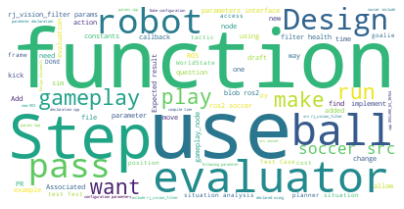

In [12]:
plt.figure(figsize=[7,7])
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.savefig("issues_cloud.png",format="png")
plt.show()

If we simply want to see this frequency with actual numbers, here are the same results represented with a bar chart. Many of these words are seen only a few times but, our total number of issues examined in the data set is only 60. Seeing a word merely twice would mean it potentially occurs in nearly 5% of issues (assuming each word is only seen once in each issue). As before, some common words like "in", "at", "Robojackets", ect. are not included because they are not particularly useful to examine.

In [13]:
#stopwords
multiple_counts = {word: multiple_counts[word] for word in multiple_counts if word not in stopwords}
#let's look at top 15 only
word_count = pd.Series(multiple_counts)
word_count = word_count.sort_values(ascending=False)

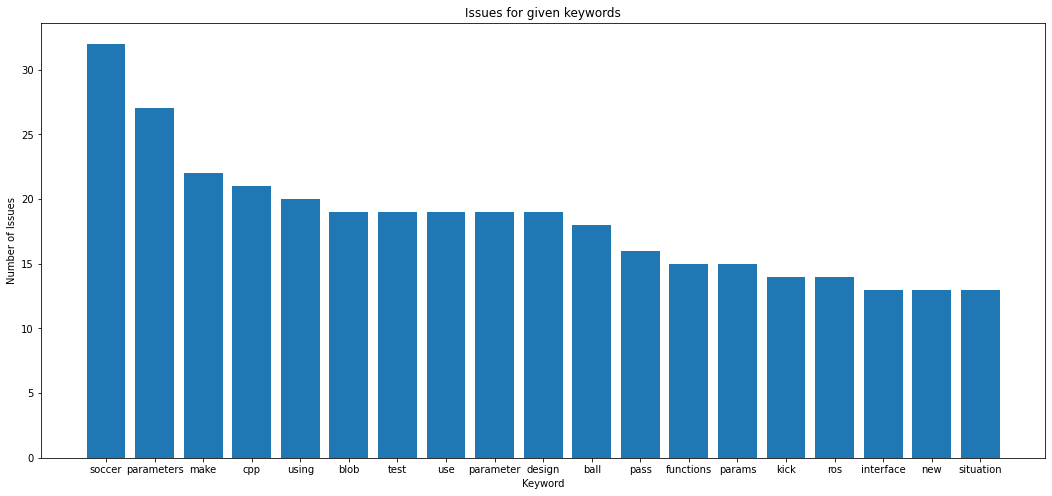

In [15]:
plt.figure(figsize=[18,8])
plt.bar(word_count[0:19].index, word_count[0:19])
plt.ylabel("Number of Issues")
plt.xlabel("Keyword")
plt.title("Issues for given keywords")
plt.show()

It may seem obvious for a robot soccer team to have the word "soccer" as the top occurring term! But in this case, the software that connects with the referee computers and gives the behavioral instructions to the teams' robots is in a folder/module called "soccer".

"Parameters", "parameter", and "params" are also three common terms. If the numbers of these are combined, they would exceed any of the other keywords by a large margin. The C++ library used Robojackets for communication between many of the subsystems in the robot, ROS (another common keyword), allows users to send parameters to change robot behaviors on the fly. Implementing these in a way where the team can use them effectively during matches or testing is probably a priority.

"Blob" is used to link users to areas within the code repository and does not refer to any specific function/goal of the team. Similarly, "cpp" simply refers to the language used for much of the codebase.

Finally, many words related to gameplay implementation also occur frequently. These include "ball", "kick", and "pass". Because the team has been internally frequently discussing the construction of tactics (which can be read about in more detail on the [software wiki](https://robojackets.github.io/robocup-software/md_doc__gameplay.html)), it is good that the occurrances of issues in the software repository are in line with this priority.

In [16]:
issues_df.columns

Index(['id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked',
       'assignee', 'assignees', 'milestone', 'comments', 'created_at',
       'updated_at', 'closed_at', 'author_association', 'active_lock_reason',
       'pull_request', 'body', 'reactions', 'timeline_url',
       'performed_via_github_app'],
      dtype='object')

## Checking our Priorities

In [17]:
labels_dict = {}

for i in range(len(issues_df['labels'])):
    if len(issues_df['labels'].iloc[i]) > 0:
        labels_dict[i] = issues_df['labels'].iloc[i]

In [32]:
#print(list(labels_dict.keys()))
flag_names = []
flag_dict_keys = []
for key in labels_dict.keys():
    for label in labels_dict[key]:
        flag_names.append(label['name'])
        flag_dict_keys.append(key)

unique_flags = set(flag_names)
unique_flags = list(unique_flags)

In [44]:
flags_dict = defaultdict(list)
for i in range(0, len(flag_dict_keys)):
    flags_dict[flag_dict_keys[i]].append(flag_names[i])

In [39]:
flag_df_dict = defaultdict(list)

for flag in unique_flags:
    for i in range(0, max(flag_dict_keys)+1):
        if flag in flags_dict[i]:
            flag_df_dict[flag].append(1)
        else:
            flag_df_dict[flag].append(0)

flag_df_dict = dict(flag_df_dict)

In [40]:
flags_df = pd.DataFrame.from_dict(flag_df_dict)

In [43]:
flags_df.iloc[10:15]

status / need-triage  area / soccer  exp / novice (1)  priority / high  \
10                     1              0                 0                0   
11                     0              0                 1                0   
12                     0              0                 1                0   
13                     0              0                 1                0   
14                     0              0                 1                0   

    Epic  priority / low  area / support  exp / master (4)  \
10     0               0               0                 0   
11     0               1               0                 0   
12     0               1               0                 0   
13     0               1               0                 0   
14     0               1               0                 0   

    exp / new-member-project  type / new feature  type / bug  \
10                         0                   1           0   
11                         0                   0           0   
12                         0                   0           0   
13                         0                   0           0   
14                         0                   0           0   

    pull request todo  status / new  
10                  0             1  
11                  1             0  
12                  1             0  
13                  1             0  
14                  1             0

In [45]:
#make a bar graph visualizing the flag counts
#do we have a lot of issues that beginners can work on? what about challenging projects for experienced members?
#how does this compare to the make up of the team?
#want to do: see which words occur most often with which flags - probably do the other way around:
#see which words occur for each flag and how frequently. basically do word count dicts for each flag
#or maybe just the high priority flags :)